<a href="https://colab.research.google.com/github/ekaterina-kozh/SQL_EX/blob/main/water_analiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Придумай механизм нанесения водных знаков (может быть обычный текст) на
изображения.
Нанеси водные знаки на входные изображения.
Подумай над архитектурой автокодировщика.
Обучи модель и сделай предсказания на контрольной выборке.
Продемонстрируй работу модели путём вывода не менее 10 примеров из тестовой выборки, содержащих: исходное изображение, изображение с водными знаками, предсказанное изображение и изображение шума (полученное путём вычитания предсказанного изображения из изображения).

In [ ]:
# Работа с массивами данных
import numpy as np

# Графики
import matplotlib.pyplot as plt
%matplotlib inline

# Конструктор модели
from keras.models import Model

# Утилиты
from keras import utils

# Слои
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, Conv2DTranspose, BatchNormalization

# Оптимизатор
from keras.optimizers import Adam

# Коллбэки
from keras.callbacks import EarlyStopping

# Opencv для работы с изображениями
import cv2

# Системный команды
import os

# Аугментация
from keras.src.legacy.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Расщипление выборок
from sklearn.model_selection import train_test_split

# Случайный выбор
import random

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/watermarked.zip

--2024-09-15 08:27:55--  https://storage.yandexcloud.net/academy.ai/watermarked.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 731796045 (698M) [application/x-zip-compressed]
Saving to: ‘watermarked.zip’

watermarked.zip     100%[===================>] 697.89M  53.8MB/s    in 13s     

2024-09-15 08:28:08 (55.5 MB/s) - ‘watermarked.zip’ saved [731796045/731796045]



In [ ]:
!unzip -qo "watermarked.zip" -d ./watermarked

In [ ]:
os.listdir('./watermarked/wm-nowm') # папки с изображениями

['valid', 'train']

In [ ]:
# Задаем пути к папкам
train_path = './watermarked/wm-nowm/train' # тренировочные образцы
valid_path = './watermarked/wm-nowm/valid' # контрольные образцы

In [ ]:
os.listdir(train_path)

['watermark', 'wat', 'no-watermark']

In [ ]:
os.listdir(valid_path)

['watermark', 'wat', 'no-watermark']

In [ ]:
train_path_no = os.path.join(train_path, 'no-watermark')
valid_path_no = os.path.join(valid_path, 'no-watermark')

In [ ]:
#Функция добаления вводного знака
def add_watermark(input_image_path, output_image_path, watermark_text, position=(30, 30), font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=1, color=(255, 255, 255), thickness=2):
    # Чтение изображения
    image = cv2.imread(input_image_path)

    # Нанесение текста на изображение
    cv2.putText(image, watermark_text, position, font, font_scale, color, thickness)

    # Сохранение изображения с водяным знаком
    cv2.imwrite(output_image_path, image)

Создадим папки в которых будет содежаться картинки с вводным знаком.

In [ ]:
os.makedirs('./watermarked/wm-nowm/train/wat', exist_ok=True)

In [ ]:
os.makedirs('./watermarked/wm-nowm/valid/wat', exist_ok=True)

In [ ]:

# Получаем список всех файлов в папке с изображениями без водяных знаков
image_files = os.listdir(train_path_no)

# Вводный знак
watermark_text = "watermark"

# Наносим водяные знаки на все изображения
for image_file in image_files:
    input_image_path = os.path.join(train_path_no, image_file)
    output_image_path = os.path.join('./watermarked/wm-nowm/train/wat', image_file)
    add_watermark(input_image_path, output_image_path, watermark_text)

In [ ]:
# Получаем список всех файлов в папке с изображениями без водяных знаков
image_files = os.listdir(valid_path_no)

# Наносим водяные знаки на все изображения
for image_file in image_files:
    input_image_path = os.path.join(valid_path_no, image_file)
    output_image_path = os.path.join('./watermarked/wm-nowm/valid/wat', image_file)
    add_watermark(input_image_path, output_image_path, watermark_text)

In [ ]:
train_path_wm = os.path.join(train_path, 'wat')
valid_path_wm = os.path.join(valid_path, 'wat')

Так как в папках лежат разные наборы данных, то необходимо отобрать парные картинки с водяными знаками и без.

In [ ]:
train_nonwatermarked = [] # список файлов без водяных знаков (тренировочная выборка)
train_watermarked = []  # список файлов с водяными знаков (тренировочная выборка)
valid_nonwatermarked = [] # список файлов без водяных знаков (контрольная выборка)
valid_watermarked = [] # список файлов с водяными знаков (контрольная выборка)

# Обнаружено в датасете не соответствие, просто удалим файл
try:
    os.remove('./watermarked/wm-nowm/train/watermark/animal-dog-pet-cute.jpg')
except Exception as e:
    print(e) # вывод ошибки загрузки или масштабирования картинки

# Найдем парные файлы для тренировочной выборки
for file_no in sorted(os.listdir(train_path_no)):
    for file_wm in sorted(os.listdir(train_path_wm)):
        # Если имена файлов в обеих папках совпадают, то добавляем пути к этим файлам в списки
        if file_no == file_wm:
            train_nonwatermarked.append(os.path.join(train_path_no, file_no))
            train_watermarked.append(os.path.join(train_path_wm, file_wm))

# Найдем парные файлы для контрольной выборки
for file_no in sorted(os.listdir(valid_path_no)):
    for file_wm in sorted(os.listdir(valid_path_wm)):
        # Если имена файлов в обеих папках совпадают, то добавляем пути к этим файлам в списки
        if file_no == file_wm:
            valid_nonwatermarked.append(os.path.join(valid_path_no, file_no))
            valid_watermarked.append(os.path.join(valid_path_wm, file_wm))

[Errno 2] No such file or directory: './watermarked/wm-nowm/train/watermark/animal-dog-pet-cute.jpg'


In [ ]:
print('Обучающая выборка содержит:')
print(len(train_nonwatermarked), 'файлов без водяных знаков')
print(len(train_watermarked), 'файлов с водяными знаками')

Обучающая выборка содержит:
12477 файлов без водяных знаков
12477 файлов с водяными знаками


In [ ]:
print('Контрольная выборка содержит:')
print(len(valid_nonwatermarked), 'файлов без водяных знаков')
print(len(valid_watermarked), 'файлов с водяными знаками')

Контрольная выборка содержит:
3289 файлов без водяных знаков
3289 файлов с водяными знаками


In [ ]:
#Сократим их кол-во до 100 шт.
train_nonwatermarked = train_nonwatermarked[:100]
train_watermarked = train_watermarked[:100]
valid_nonwatermarked = valid_nonwatermarked[:100]
valid_watermarked = valid_watermarked[:100]

Загрузка картинок и их масштабирование

In [ ]:
# Размер преобразованных картинок
width = 148
height = 148
dim = (width, height)

# Функция загрузки и масштабирования картинок
def createPixelArr(files):
    data = []
    for image in files: # цикл по каждой картинке в списке
        try:
            # Загрузим изображение в матрицу (сохранив цвета, загружает как BGR)
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
            resized_arr = cv2.resize(img_arr, (width, height)) # масштабируем изображение
            data.append(resized_arr) # добавляем в список матрицу пикселей картинки
        except Exception as e:
            print(e) # вывод ошибки загрузки или масштабирования картинки
    return np.array(data) # возвращаем набор картинок как матрицу

In [ ]:
y_train = createPixelArr(train_nonwatermarked) # подготовка картинок (без знаков, обучающая выборка)
X_train = createPixelArr(train_watermarked)    # подготовка картинок (водяные знаки, обучающая выборка)

y_test = createPixelArr(valid_nonwatermarked)  # подготовка картинок (без знаков, контрольная выборка)
X_test = createPixelArr(valid_watermarked)     # подготовка картинок (водяные знаки, контрольная выборка)

Выведем первую картинку с вводным знаком и без.

In [ ]:
def showpic(mas, i):
 plt.figure(figsize=(25, 25))
 plt.subplot(5, 5, i+1)
 plt.xticks([])
 plt.yticks([])
 plt.grid(False)
    # Преобразуем картинку в формат RGB перед выводом
 plt.imshow(cv2.cvtColor(mas[i], cv2.COLOR_BGR2RGB))
 plt.show()

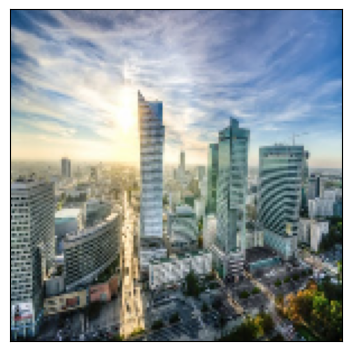

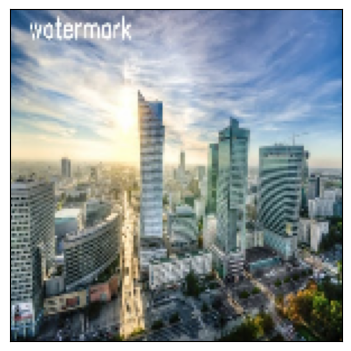

In [ ]:
showpic(y_train, 1)
showpic(X_train, 1)

In [ ]:
train_nonwatermarked = None
train_watermarked    = None
valid_nonwatermarked = None
valid_watermarked    = None

Аугментация данных

In [ ]:
# Функции аугментации изображений

def data_augmentation(inputImage): # функция прогоняет картинки через все методы аугментации
    return randomContrast(randomBrightness(inputImage)).numpy()


def randomBrightness(pic): # добавляем изображению случайную яркость от 1% до 20%
    return tf.image.random_brightness(pic, random.uniform(0.01, 0.2), 1)

def randomContrast(pic): # добавляем изображению случайную контрастность от 5% до 50%
    return tf.image.random_contrast(pic, 0.2, 0.7, 1)

data_augmented_X = []
data_augmented_y = []

for image in X_train:
    data_augmented_X.append(data_augmentation(image))

for image in y_train:
    data_augmented_y.append(data_augmentation(image))

Проверим результат

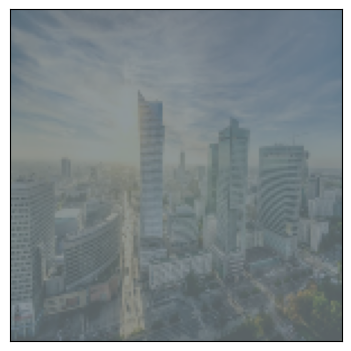

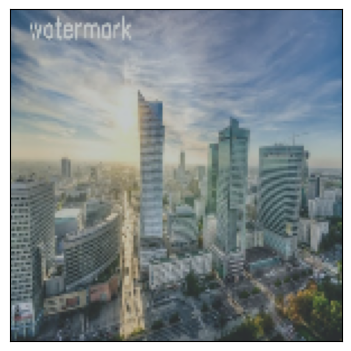

In [ ]:
showpic(data_augmented_y, 1)
showpic(data_augmented_X, 1)

In [ ]:
#Объединим тренировочную и контрольную выборки с их аугментированными версиями
X_train = np.append(X_train, data_augmented_X, axis=0)
y_train = np.append(y_train, data_augmented_y, axis=0)

In [ ]:
#Нормальзуем данные
X_train = X_train.astype('float32') / 255.
y_train = y_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

Модель автокодировщика

In [ ]:
def create_model(img_x, img_y, channel):
    inputs = Input(shape=(img_x, img_y, channel))

    # Кодировщик - сжимает входные данные в латентное пространство
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    h = MaxPooling2D((2, 2), padding='same')(x)

    # Декодировщик - реконструирует сжатое представление
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(h)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)

    outputs = Conv2D(channel, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse',  metrics=['acc'])
    return model

In [ ]:
watermark_auto_encoder = create_model(width, height, 3)

Схема сверточного автокодировщика:


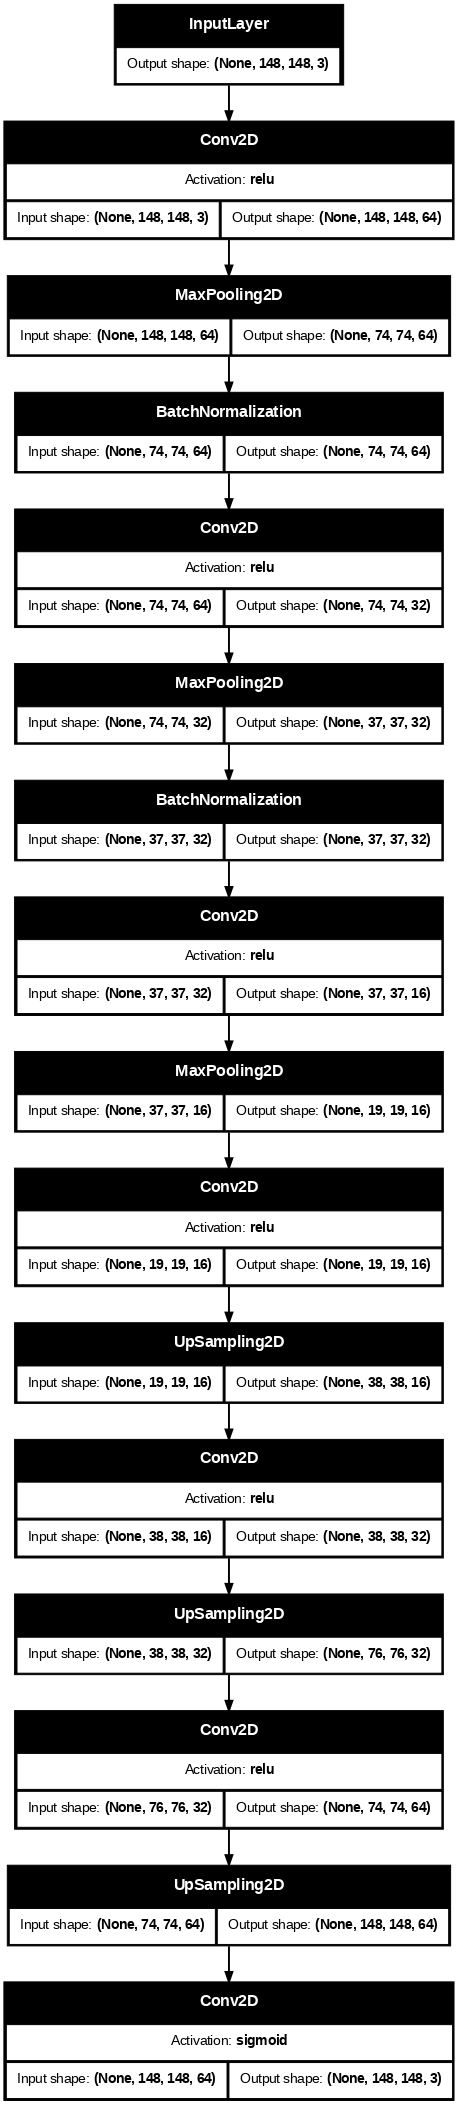

In [ ]:
print('Схема сверточного автокодировщика:')
utils.plot_model(watermark_auto_encoder, show_shapes=True, dpi=70, show_layer_activations=True, expand_nested=True)

Сделаем 150 эпох с колбэком.

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=6, restore_best_weights=True)
history = watermark_auto_encoder.fit(X_train, y_train, batch_size=64, epochs=150, callbacks=[early_stop])

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - acc: 0.6889 - loss: 0.0156
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - acc: 0.6800 - loss: 0.0153
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - acc: 0.6673 - loss: 0.0161
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - acc: 0.6639 - loss: 0.0157
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - acc: 0.6799 - loss: 0.0157
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step - acc: 0.6772 - loss: 0.0154
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - acc: 0.6688 - loss: 0.0160
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - acc: 0.6778 - loss: 0.0165
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - acc: 0.6635 - loss: 0.0155
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - acc: 0.6681 - loss: 0.0153
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - acc: 0.6613 - loss: 0.0154
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step - acc: 0.6845 - loss: 0.0163
Epoch 13/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - acc: 0.68

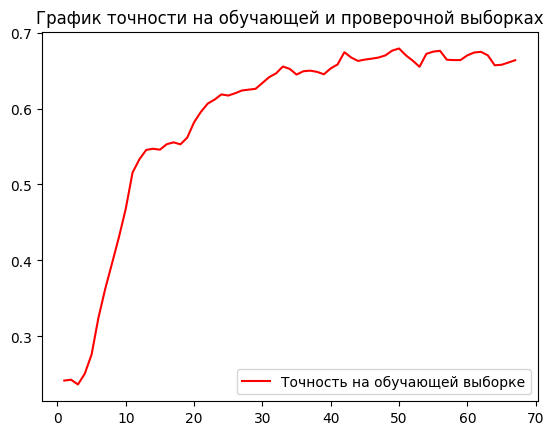

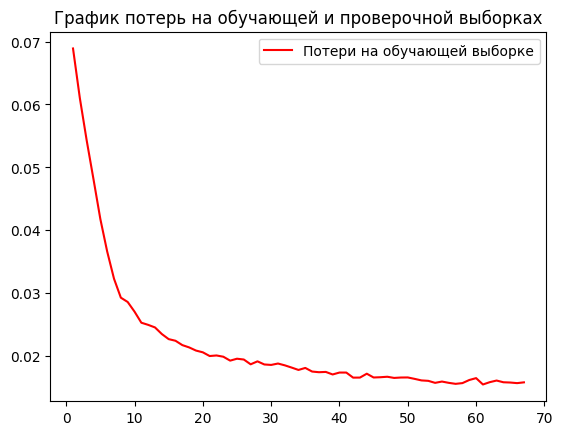

In [ ]:
import matplotlib.pyplot as plt           # библиотека для рисования графиков
acc = history.history['acc']              # данные о точности на обучающей выборке
loss = history.history['loss']            # данные об ошибке на обучающей выборке
epochs = range(1, len(acc) + 1)           # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

Оценка модели

In [ ]:
result = watermark_auto_encoder.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 886ms/step


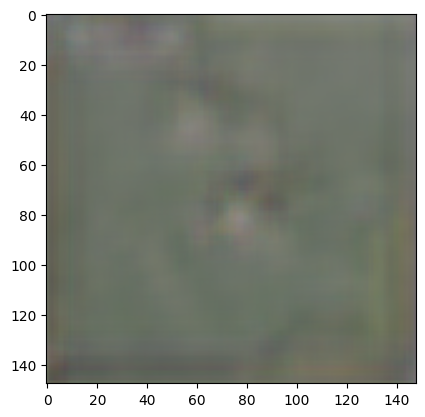

In [ ]:
plt.imshow(cv2.cvtColor(result[1], cv2.COLOR_BGR2RGB))

In [ ]:
# Функция для вычисления шума
def calculate_noise(original, predicted, i):
# Создаем фигуру для отображения изображений шума
  plt.figure(figsize=(25, 25))
  noise = original[i].astype('float32') - predicted[i].astype('float32')
  noise_rgb = cv2.cvtColor(noise, cv2.COLOR_BGR2RGB)
  # Создаем подграфик
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(noise_rgb)
  # Показываем все изображения
  plt.show()

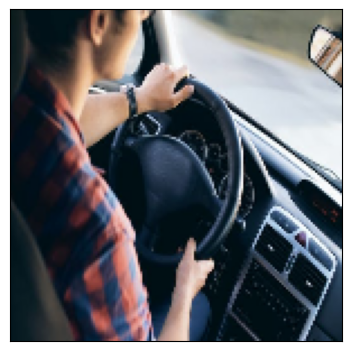

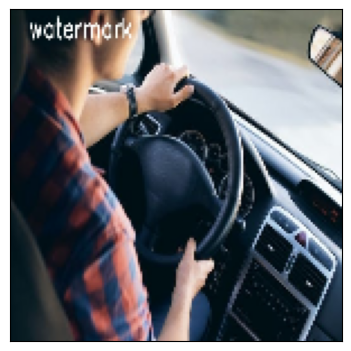

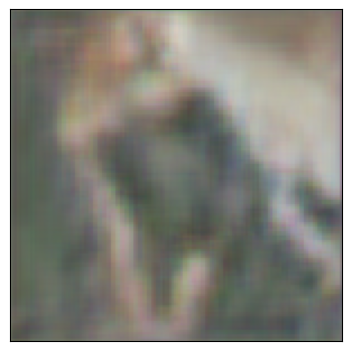

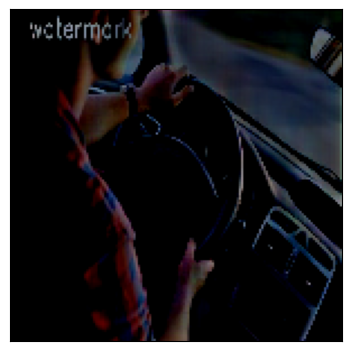

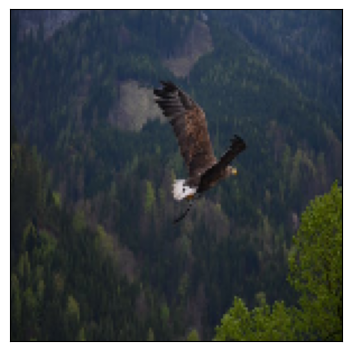

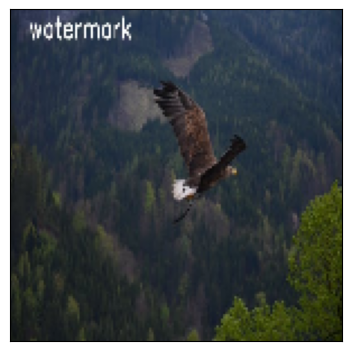

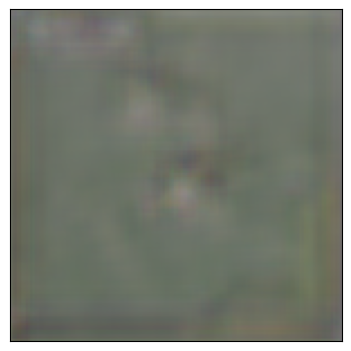

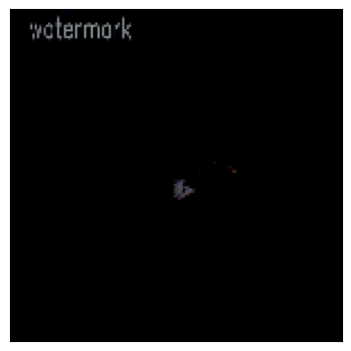

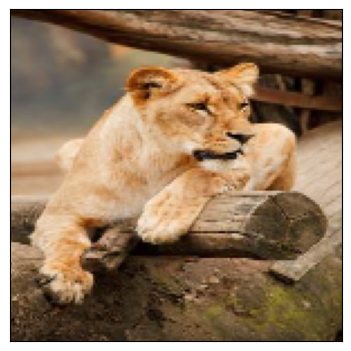

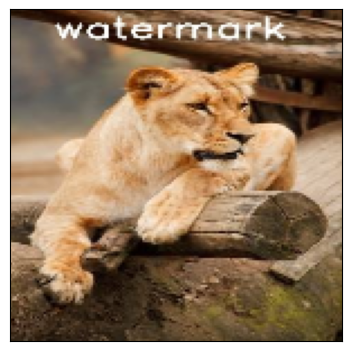

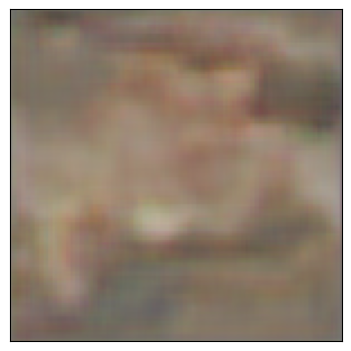

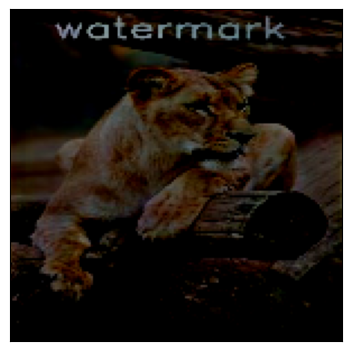

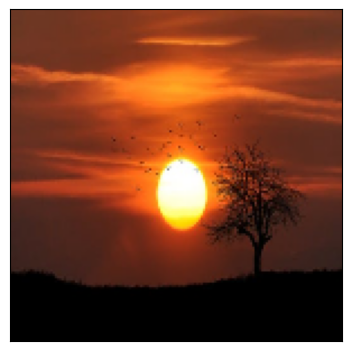

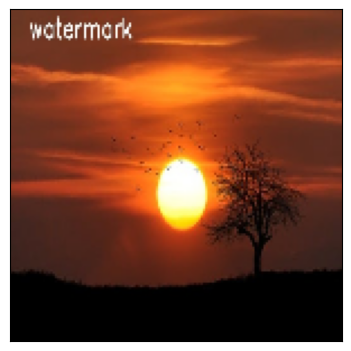

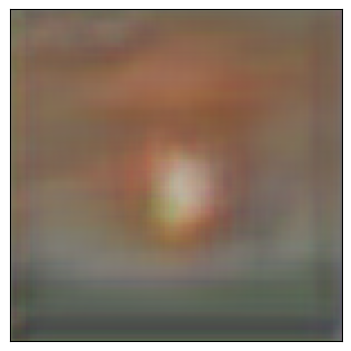

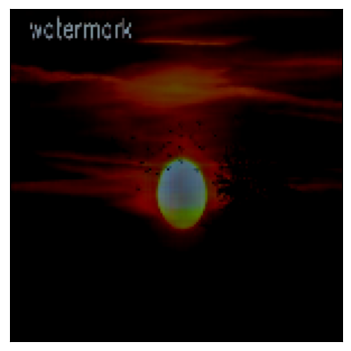

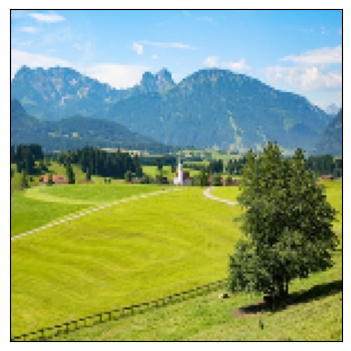

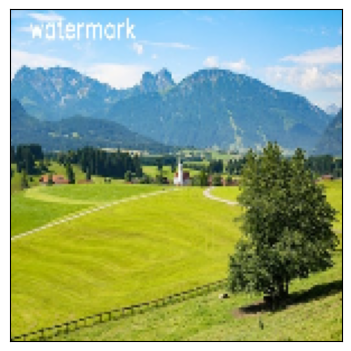

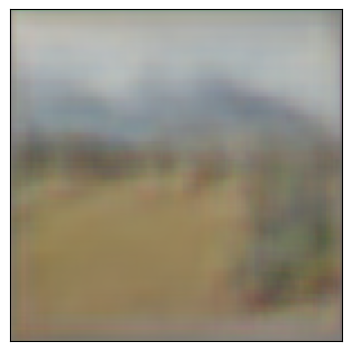

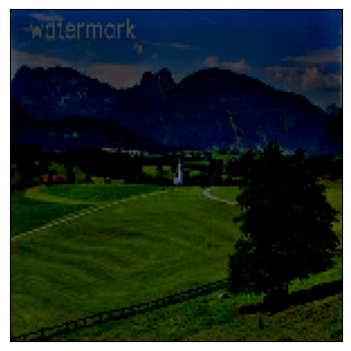

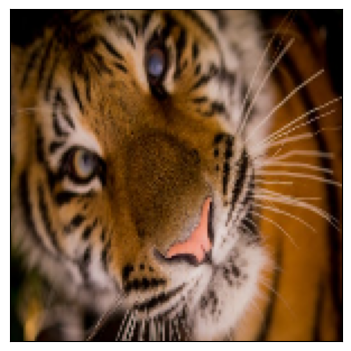

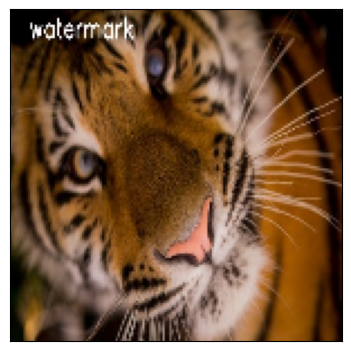

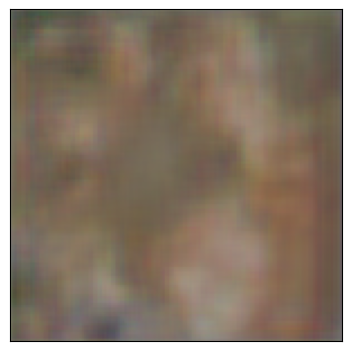

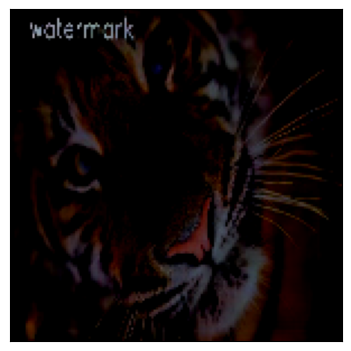

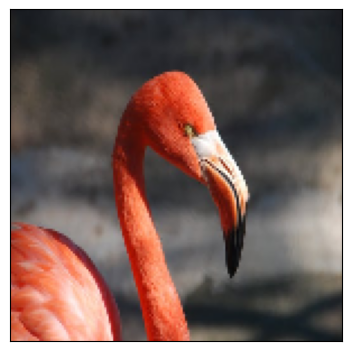

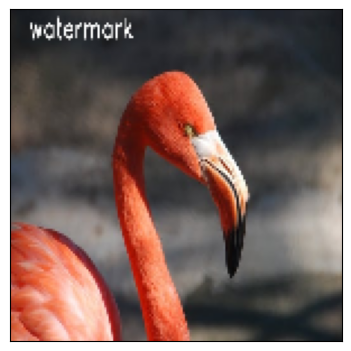

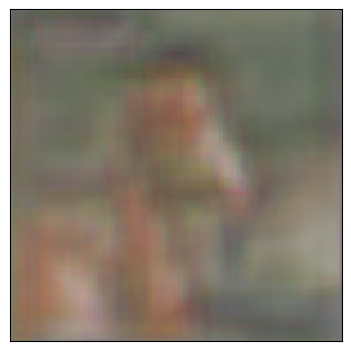

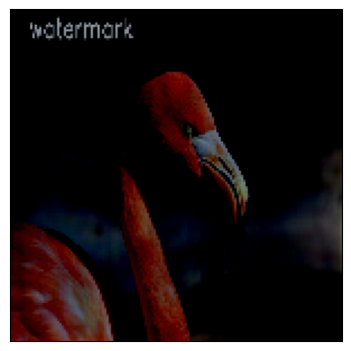

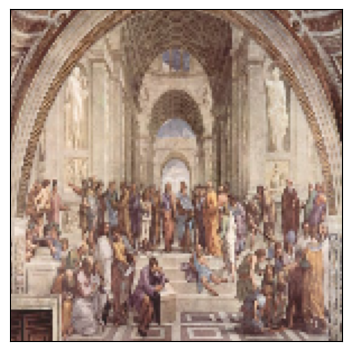

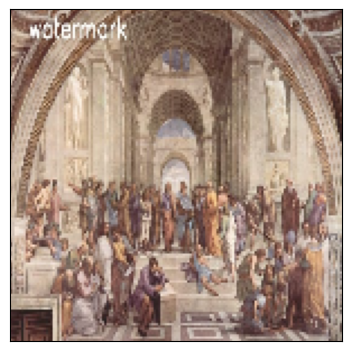

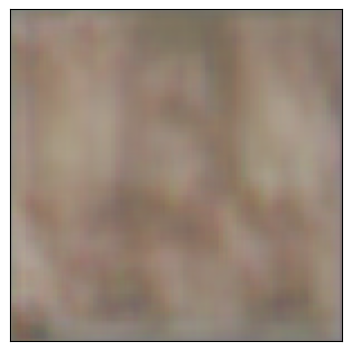

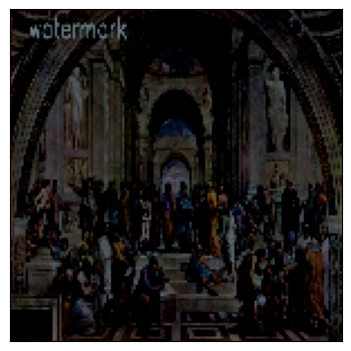

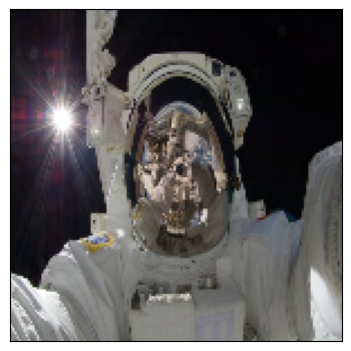

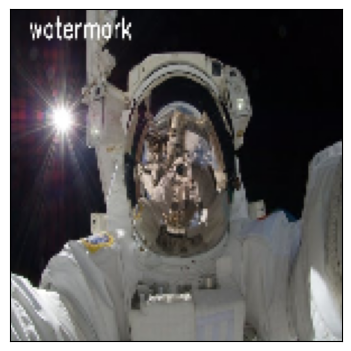

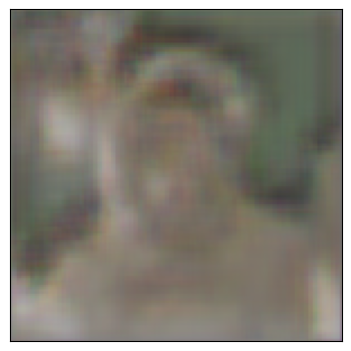

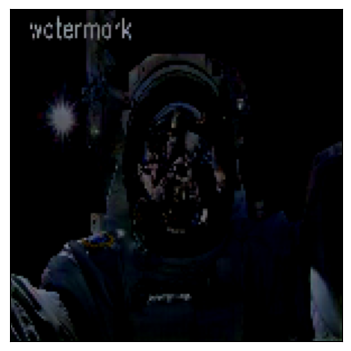

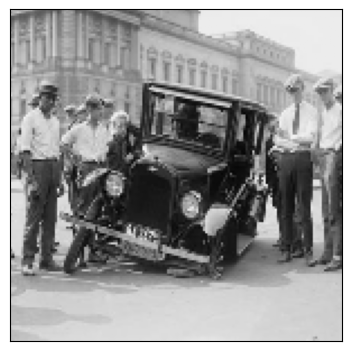

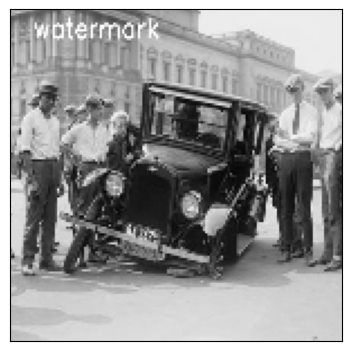

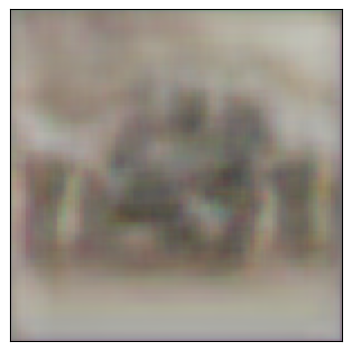

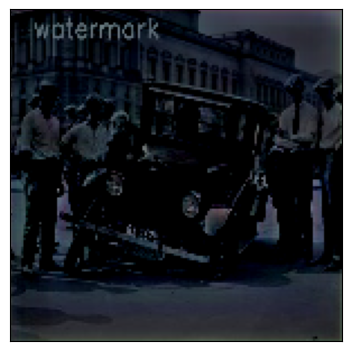

In [ ]:
for i in range(10):
  showpic(y_test, i) #Без вводных наков
  showpic(X_test, i) #С вводным знаком
  showpic(result, i) #Предсказанное изображение
  calculate_noise(X_test, result, i) #Изображение шума


Итак, мы вывели 10 примеров из тестовой выборки, содержащих: исходное изображение, изображение с водными знаками, предсказанное изображение и изображение шума (полученное путём вычитания предсказанного изображения из изображения).